In [1]:
import os
import sys
sys.path.insert(0, './utils/')
from utils import load_data, normalize_data, format_data, split_data
from utils import train_model, plot_train_val, forecast, forecast_analysis, experiment


In [2]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Model with Dense layers over time steps

In [3]:
def get_model_dense(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = Dense(500, activation='relu')(m)
    m = BatchNormalization()(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    m = GlobalAveragePooling1D()(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

## Model with TimeDistributed wrapper

In [4]:
def get_model_timedist(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = TimeDistributed(Dense(500, activation='relu'))(m)
    m = BatchNormalization()(m)
    m = TimeDistributed(Dense(200, activation='relu'))(m)
    m = TimeDistributed(Dense(1, activation='relu'))(m)
    m = GlobalAveragePooling1D()(m) #avg pool or m =  Flatten()(m) m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

### San Juan

W1001 20:26:06.848541 140373195949888 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?, 23, 170)
Training...
Elapsed Time: 25.41318416595459


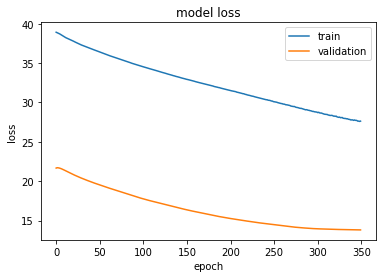

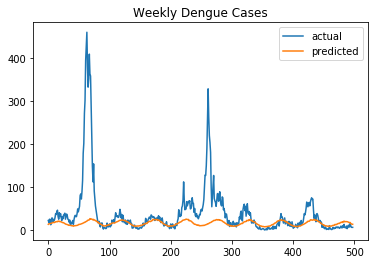

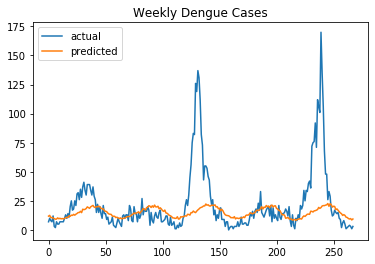

Forecast MAE: 13.915690514578747


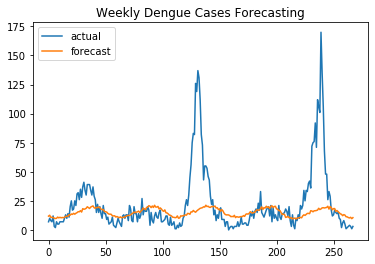

In [5]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'epochs': 350,
    'city':'sj'
}
df_results_sj = experiment(get_model_dense, hyperparameters)

### Iquitos

(?, 23, 150)
Training...
Elapsed Time: 53.90328907966614


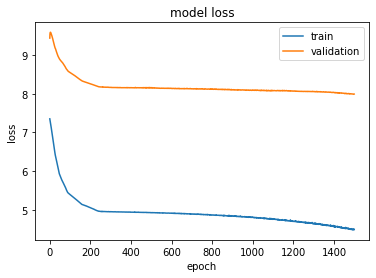

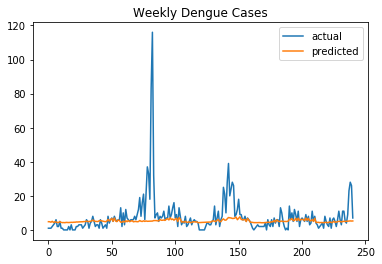

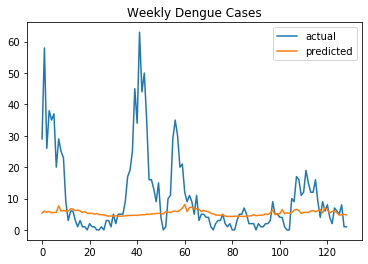

Forecast MAE: 8.007507320522338


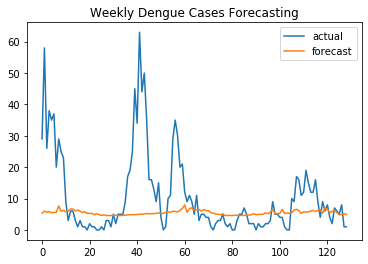

In [6]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 150,
    'epochs': 1500,
    'city':'iq'
}
df_results_iq = experiment(get_model_dense, hyperparameters)

## Model / Train / Forecast - TimeDistributed Model

### San Juan

(?, 23, 170)
Training...
Elapsed Time: 20.03995990753174


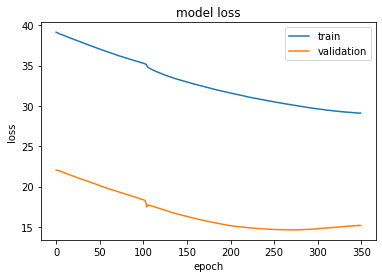

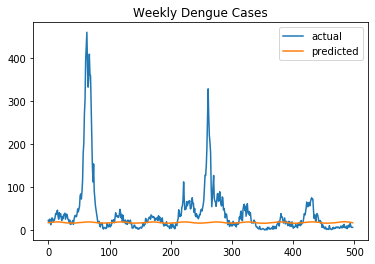

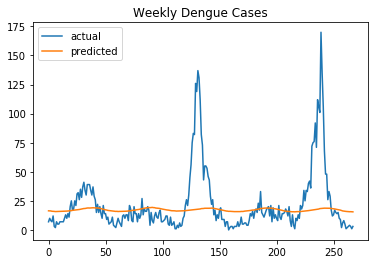

Forecast MAE: 15.167842149734497


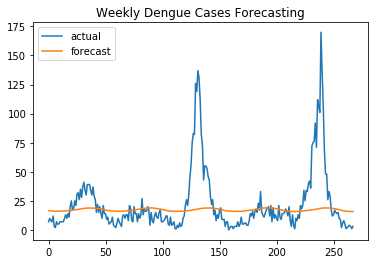

In [7]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 170,
    'epochs': 350,
    'city':'sj'
}
df_results_sj = experiment(get_model_timedist, hyperparameters)

### Iquitos

(?, 23, 150)
Training...
Elapsed Time: 19.18219494819641


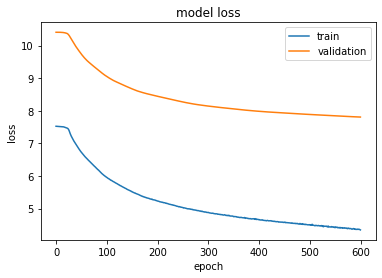

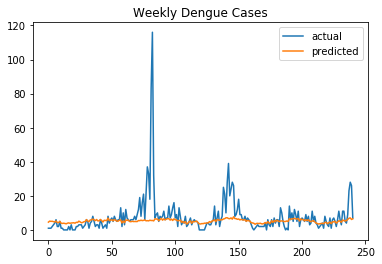

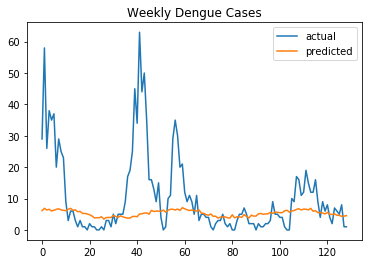

Forecast MAE: 7.8296703793281734


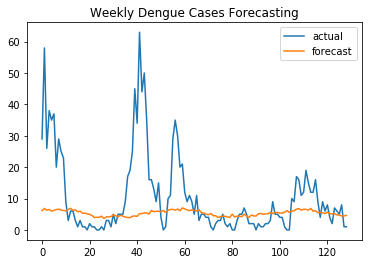

In [8]:
hyperparameters = {
    'train_split_percent': 0.65,
    'lookback_window': 150,
    'epochs': 600,
    'city':'iq'
}
df_results_iq = experiment(get_model_timedist, hyperparameters)